# Plot distance-based treatment effects for many cohorts

Here we create plots of the effect on outcomes of redirection from the nearest acute stroke unit to the nearest thrombectomy centre in a generic geography.

## Plain English summary

This notebook takes the data that we calculated in the previous notebook. It creates plots of the differences in travel times and outcomes around a grid depending on the difference in travel time from the patient to their nearest stroke unit and from the patient to the farther MT unit. We will make plots for the separate nLVO, LVO, and treated ischaemic groups, and then one big plot with all of these together.

## Aims

For each of the following cohorts:
+ nLVO treated with IVT
+ LVO, mix of patients treated with IVT only, with MT only, and with both IVT and MT
+ Combined nLVO and LVO "treated ischaemic population"

We will make the following circle plots:
+ difference in travel time from patient to nearest unit and from patient to MT unit.
+ difference in added utility
+ difference in proportion of patients with mRS less than or equal to 2
+ difference in mean mRS score.

We first make the plots for each cohort separately and then make one big plot with all of the data together.

## Method

This notebook is a continuation of the [previous document](05_geography_outcomes.ipynb). That document calculated the travel time grids and outcome results that are loaded in at the start of this notebook.

## Notebook admin

In [1]:
# Import packages
import numpy as np 
import pandas as pd
import copy
# For plotting:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap  # for the time colour map
# For keeping track of files:
import os
from dataclasses import dataclass

# Custom packages:
from stroke_outcome.continuous_outcome import Continuous_outcome
from geography_plot import find_mask_within_flattened_circle, make_new_cmap_diverging, circle_plot, make_levels_with_zeroish

In [2]:
# Set up MatPlotLib
%matplotlib inline

In [3]:
# Keep notebook cleaner once finalised
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    dir_output = 'output'
    dir_images = 'images'
    file_grid_ivt = 'generic_geography_grid_time_travel_directly_to_ivt.csv'
    file_grid_diff = 'generic_geography_grid_time_travel_directly_diff.csv'
    file_grid_dict = 'generic_geography_dict_travel_grid.csv'
    file_outcomes_nlvo = 'generic_geography_df_nlvo_ivt_diff.csv'
    file_outcomes_lvo = 'generic_geography_df_lvo_diff.csv'
    file_outcomes_mix = 'generic_geography_df_mixed_diff.csv'

paths = Paths()

## Import data

### Travel times

In [5]:
grid_time_travel_directly_to_ivt = np.genfromtxt(
    os.path.join(paths.dir_output, paths.file_grid_ivt), delimiter=',')
grid_time_travel_directly_diff = np.genfromtxt(
    os.path.join(paths.dir_output, paths.file_grid_diff), delimiter=',')

In [6]:
dict_travel_grid = pd.read_csv(
    os.path.join(paths.dir_output, paths.file_grid_dict),
    index_col=0, header=None).squeeze().to_dict()

In [7]:
dict_travel_grid

{'ivt_x': 0,
 'ivt_y': 0,
 'mt_x': 0,
 'mt_y': -60,
 'travel_ivt_to_mt': 60,
 'time_travel_max': 60,
 'grid_step': 1,
 'grid_xy_max': 62}

### Outcomes

In [8]:
df_nlvo_ivt_diff = pd.read_csv(
    os.path.join(paths.dir_output, paths.file_outcomes_nlvo),
    index_col=None)
df_lvo_diff = pd.read_csv(
    os.path.join(paths.dir_output, paths.file_outcomes_lvo),
    index_col=None)
df_mixed_diff = pd.read_csv(
    os.path.join(paths.dir_output, paths.file_outcomes_mix),
    index_col=None)

Calculate some values that will help with the circle plots later.

The extent is used to scale the sizes of the grids from pixels into times in minutes, because we might not have set one minute per pixel and because the default grid has (0, 0) in the corner but we want (0, 0) in the centre.

The grid mask is used to find which pixels of the grid (`coords_valid`) fall within the area that will be shown in the circle plot. In other words, we want to exclude the pixels that are near the MT unit or are too far into the corners to fall within the largest circle plotted. The mask will be used later to help find sensible colour scales for the plots instead of scaling the colours to include a bunch of data that won't even be displayed.

In [9]:
extent = [
    -dict_travel_grid['grid_xy_max'] - dict_travel_grid['grid_step']*0.5,
    +dict_travel_grid['grid_xy_max'] - dict_travel_grid['grid_step']*0.5,
    -dict_travel_grid['grid_xy_max'] - dict_travel_grid['grid_step']*0.5,
    +dict_travel_grid['grid_xy_max'] - dict_travel_grid['grid_step']*0.5
]

In [10]:
grid_mask = find_mask_within_flattened_circle(
    grid_time_travel_directly_diff, 
    grid_time_travel_directly_to_ivt, 
    dict_travel_grid['time_travel_max']
)

coords_valid = np.where(grid_mask<1)

## Combined circle plots

### Setup

Find the actual minimum and maximum values across all cohorts for each outcome type:

In [11]:
limit_dict = {}

for outcome in ['added_utility', 'mrs_less_equal_2', 'mrs_shift']:
    vmin = np.inf
    vmax = -np.inf

    for df in [df_nlvo_ivt_diff, df_lvo_diff, df_mixed_diff]:
        values = df[outcome].values.reshape(grid_time_travel_directly_diff.shape)
        values = values[coords_valid]
                  
        vmin_here = np.min(values)
        vmax_here = np.max(values)

        vmin = vmin_here if vmin_here < vmin else vmin
        vmax = vmax_here if vmax_here > vmax else vmax
    
    limit_dict[outcome] = {}
    limit_dict[outcome]['vmin'] = vmin
    limit_dict[outcome]['vmax'] = vmax

In [12]:
pd.DataFrame(limit_dict)

,added_utility,mrs_less_equal_2,mrs_shift
vmin,-0.025948,-0.028315,-0.427215
vmax,0.080942,0.085876,0.147252


Create dictionaries of parameters that will be shared across plots.

In [13]:
# Base colour map:
cmap = 'bwr'

In [14]:
plot_params = {
    'added_utility': {
        'col': 'added_utility',
        'title': 'Change in mean utility',
        # Colours:
        'cbar_label': 'Mean added utility\nby attending MT unit directly',
        'vmin': -0.030,
        'vmax': 0.090,
        'cmap_base': f'{cmap}_r',
        # Contours:
        'level_step': 0.015,
        'zeroish': 1e-3,
    },
    'mrs_shift': {
        'col': 'mrs_shift',
        'title': 'Change in mean mRS',
        # Colours:
        'cbar_label': 'Mean change in\nmRS improvement\nby attending MT unit directly',
        'vmin': -0.5,
        'vmax': 0.2,
        'cmap_base': f'{cmap}',
        # Contours:
        'level_step': 0.1,
        'zeroish': 4e-3,
    },
    'mrs_less_equal_2': {
        'col': 'mrs_less_equal_2',
        'title': 'Change in proportion with mRS <=2',
        # Colours:
        'cbar_label': 'Change in\nproportion with mRS <=2\nby attending MT unit directly',
        'vmin': -0.03,
        'vmax': 0.09,
        'cmap_base': f'{cmap}_r',
        # Contours:
        'level_step': 0.015,
        'zeroish': 1e-3,
    },
    'time': {
        'col': None,
        'title': 'Additional travel time to MT centre',
        # Colours:
        'cbar_label': 'Extra travel time\nto MT unit\n(minutes)',
        'vmin': 0,
        'vmax': dict_travel_grid['travel_ivt_to_mt'],
        'cmap_base': None,
        # Contours:
        'level_step': 10,
        'zeroish': 0.001,
    },
}

Make new colour maps that are based on a diverging colour map but have the zero (white) off-centre:

In [15]:
for key, params_dict in plot_params.items():
    if params_dict['cmap_base'] is None:
        # Time colour map.
        # For the time colours, take only the right half of the base cmap:
        colours_time = plt.get_cmap(cmap)(np.linspace(0.5, 1.0, 256))
        new_cmap = LinearSegmentedColormap.from_list(f'cmap_time', colours_time)
    else:
        # Outcome colour map.
        new_cmap = make_new_cmap_diverging(
            params_dict['vmin'],
            params_dict['vmax'],
            cmap_base=params_dict['cmap_base'],
            cmap_name=f'cmap_{key}'
        )
    plot_params[key]['cmap'] = new_cmap

Define contour levels for plotting: 

In [16]:
for key, params_dict in plot_params.items():
    plot_params[key]['levels'] = make_levels_with_zeroish(
        params_dict['level_step'],
        params_dict['vmax'],
        zeroish=params_dict['zeroish'],
        vmin=params_dict['vmin']
    )

### Plotting

The following big cell makes the plots.

In [17]:
def outcome_circle_plots(
        grid_times_diff,
        df_diff,
        dict_travel_grid,
        plot_params,
        title='',
        savename=''
    ):

    time_step_circle = 5
    circ_linewidth = 0.5

    # Plot setup:  
    fig, axs = plt.subplots(
        2, 4, figsize=(15,4), 
        gridspec_kw={'wspace':0.2, 'hspace':0.0, 'height_ratios':[20,1]}
    )
    
    plot_params['time']['ax'] = axs[0,0]
    plot_params['time']['ax_cbar'] = axs[1,0]
    plot_params['added_utility']['ax'] = axs[0,1]
    plot_params['added_utility']['ax_cbar'] = axs[1,1]
    plot_params['mrs_shift']['ax'] = axs[0,2]
    plot_params['mrs_shift']['ax_cbar'] = axs[1,2]
    plot_params['mrs_less_equal_2']['ax'] = axs[0,3]
    plot_params['mrs_less_equal_2']['ax_cbar'] = axs[1,3]

    for i, params in enumerate(plot_params.values()):
        if params['col'] != None:
            grid = df_diff[params['col']].values.reshape(grid_times_diff.shape)
        else:
            grid = grid_times_diff

        if params['level_step'] is None:
            params['cbar_ticks'] = None
        else:
            params['cbar_ticks'] = np.arange(
                params['vmin'], params['vmax'] + params['level_step'], params['level_step'])
        
        circle_plot(
            grid,
            dict_travel_grid['travel_ivt_to_mt'],
            dict_travel_grid['time_travel_max'],
            time_step_circle,
            params['vmin'],
            params['vmax'],
            ivt_coords=[dict_travel_grid['ivt_x'], dict_travel_grid['ivt_y']],
            mt_coords=[dict_travel_grid['mt_x'], dict_travel_grid['mt_y']],
            extent=extent,
            imshow=0,
            ax=params['ax'],
            cax=params['ax_cbar'],
            cmap=params['cmap'],
            cbar_label=params['cbar_label'],
            cbar_orientation='horizontal',
            # cbar_format_str='{:3.2f}',
            levels=params['levels'],
            cbar_ticks=params['cbar_ticks']
        )

        if i == 0:
            # Draw legend now:
            fig.legend(loc='upper right', bbox_to_anchor=[0.9, 1.0], ncol=1, frameon=True)

        ax = params['ax']
        # ax.set_title(params['title'])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ['top', 'bottom', 'left', 'right']:
            ax.spines[spine].set_color('None')
        ax.set_ylim(-82,82)
        # Reduce font size of ax.xaxis.label
        ax.tick_params(axis='both', which='major', labelsize=9)

        # Rotate colourbar tick labels to prevent overlapping:
        for tick in params['ax_cbar'].get_xticklabels():
            tick.set_rotation(45)
            tick.set_fontsize(9)
            tick.set_horizontalalignment('center')

    # Set supertitle 
    fig.suptitle(title, fontsize=16, y=1.05)

    if len(savename) > 0:
        plt.savefig(savename, dpi=300, bbox_inches='tight')
    plt.show()

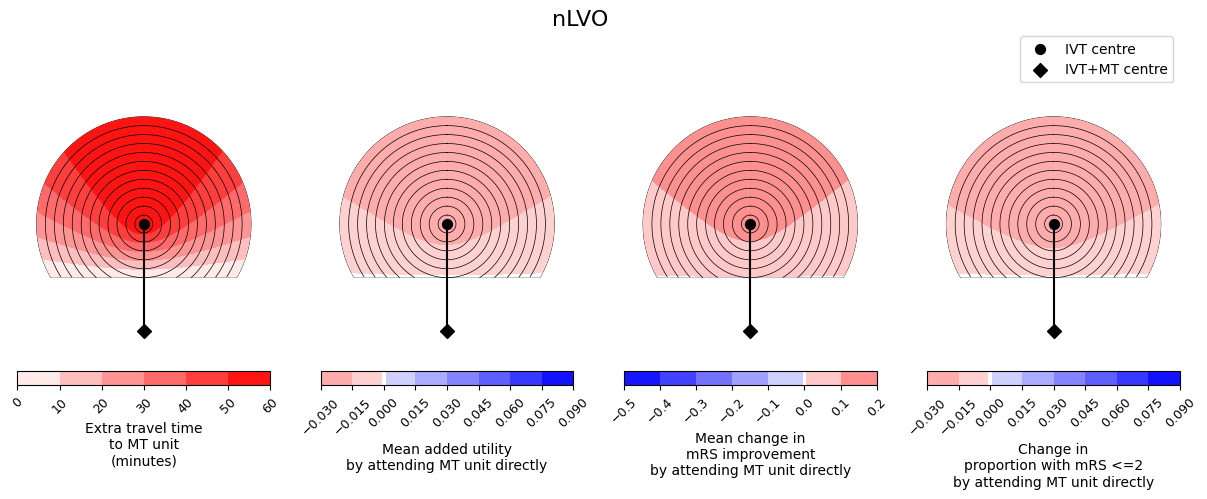

In [18]:
outcome_circle_plots(
    -grid_time_travel_directly_diff,
    df_nlvo_ivt_diff,
    dict_travel_grid,
    plot_params,
    title='nLVO',
    savename=os.path.join(paths.dir_images, f'circle_plots_stroke_type_nLVO_60_60.jpg')
)

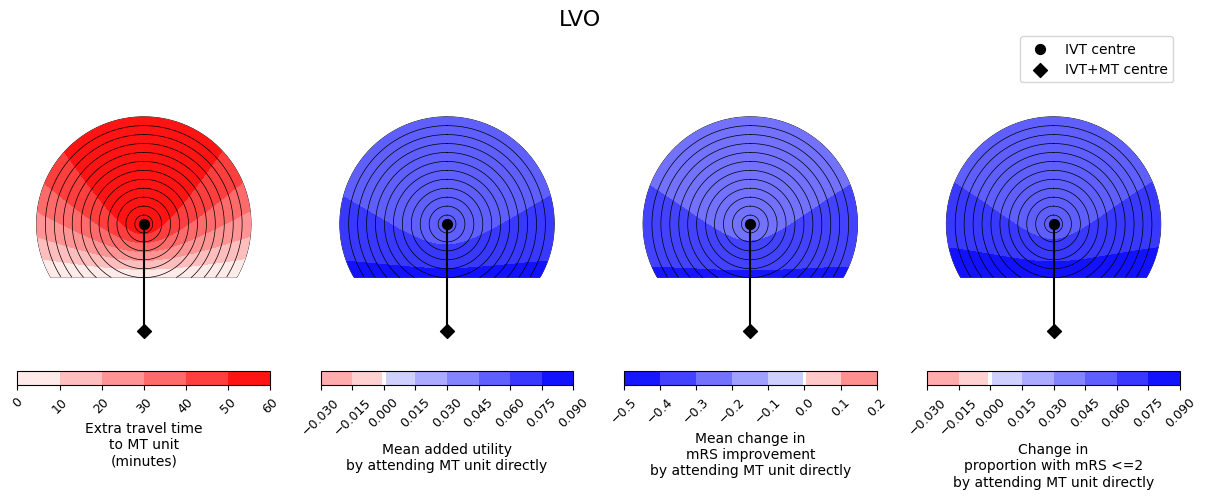

In [19]:
outcome_circle_plots(
    -grid_time_travel_directly_diff,
    df_lvo_diff,
    dict_travel_grid,
    plot_params,
    title='LVO',
    savename=os.path.join(paths.dir_images, f'circle_plots_stroke_type_LVO_60_60.jpg')
)

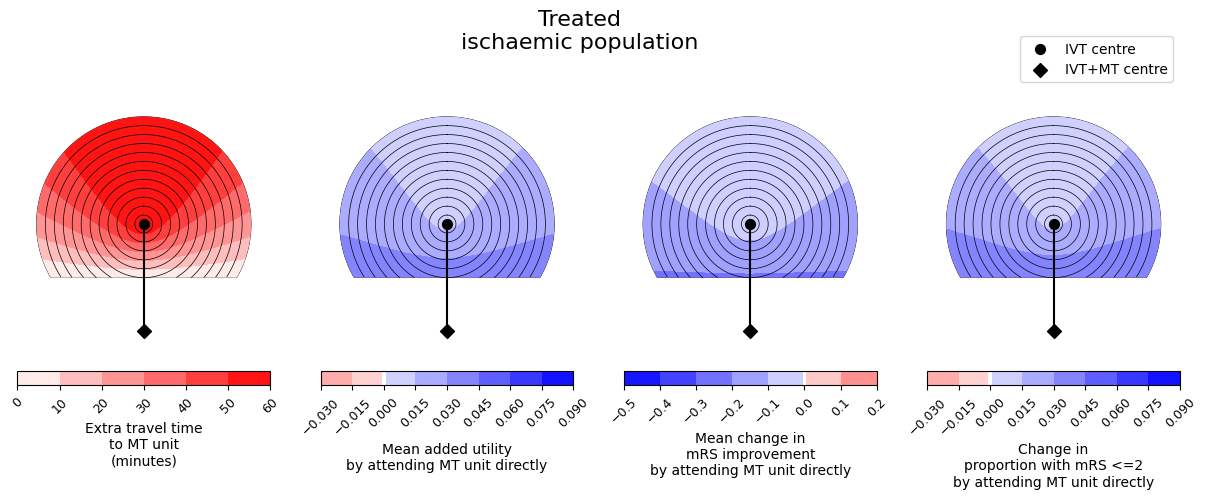

In [20]:
outcome_circle_plots(
    -grid_time_travel_directly_diff,
    df_mixed_diff,
    dict_travel_grid,
    plot_params,
    title='Treated\nischaemic population',
    savename=os.path.join(paths.dir_images, f'circle_plots_stroke_type_mix_60_60.jpg')
)

## One big figure with all circle grids

In [21]:
def big_outcome_circle_plots(
        grid_times_diff,
        dfs,
        dict_travel_grid,
        plot_params,
        title='',
        row_titles=[],
        col_titles=[],
        savename=''
    ):
    if len(row_titles) == 0:
        row_titles = [''] * len(dfs)
    if len(col_titles) == 0:
        col_titles = [''] * 4
    
    time_step_circle = 5
    circ_linewidth = 0.5

    # Plot setup:  
    fig, axs = plt.subplots(
        3, 7, figsize=(12, 10), 
        gridspec_kw={'hspace': 0.1, 'wspace': 0.0, 'width_ratios': [20, 1, 15, 20, 20, 20, 1]}
    )
    leg_drawn = False

    for d, df_diff in enumerate(dfs):
        plot_params['time']['ax'] = axs[1, 0]
        plot_params['time']['ax_cbar'] = axs[1, 1]
        plot_params['added_utility']['ax'] = axs[0, d+3]
        plot_params['added_utility']['ax_cbar'] = axs[0, -1]
        plot_params['mrs_shift']['ax'] = axs[1, d+3]
        plot_params['mrs_shift']['ax_cbar'] = axs[1, -1]
        plot_params['mrs_less_equal_2']['ax'] = axs[2, d+3]
        plot_params['mrs_less_equal_2']['ax_cbar'] = axs[2, -1]
    
        for i, params in enumerate(plot_params.values()):
            if params['col'] != None:
                grid = df_diff[params['col']].values.reshape(grid_times_diff.shape)
            else:
                grid = grid_times_diff

            if params['level_step'] is None:
                params['cbar_ticks'] = None
            else:
                params['cbar_ticks'] = np.arange(
                    params['vmin'], params['vmax'] + params['level_step'], params['level_step'])

            if ((params['col'] is None) & (d < (len(dfs) -1))):
                pass
            else:
                circle_plot(
                    grid,
                    dict_travel_grid['travel_ivt_to_mt'],
                    dict_travel_grid['time_travel_max'],
                    time_step_circle,
                    params['vmin'],
                    params['vmax'],
                    ivt_coords=[dict_travel_grid['ivt_x'], dict_travel_grid['ivt_y']],
                    mt_coords=[dict_travel_grid['mt_x'], dict_travel_grid['mt_y']],
                    extent=extent,
                    imshow=0,
                    ax=params['ax'],
                    cax=params['ax_cbar'],
                    cmap=params['cmap'],
                    cbar_label=params['cbar_label'],
                    cbar_orientation='vertical',
                    # cbar_format_str='{:3.2f}',
                    levels=params['levels'],
                    cbar_ticks=params['cbar_ticks']
                )
            
                if leg_drawn is False:
                    # Draw legend now:
                    fig.legend(loc='upper left', bbox_to_anchor=[0.13, 0.87], ncol=1, frameon=True)
                    leg_drawn = True
    
            ax = params['ax']
            # ax.set_title(params['title'])
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_xticks([])
            ax.set_yticks([])
            for spine in ['top', 'bottom', 'left', 'right']:
                ax.spines[spine].set_color('None')
            ax.set_ylim(-82,82)
            # Reduce font size of ax.xaxis.label
            ax.tick_params(axis='both', which='major', labelsize=9)

            # If there are too many colourbar tick labels, reduce them:
            if len(params['ax_cbar'].get_yticks()) > 8:
                # cticks = params['ax_cbar'].get_yticks()
                # params['ax_cbar'].set_yticks(cticks[::2])
                # params['ax_cbar'].set_yticks(cticks, minor=True)
                cticks = np.array(params['ax_cbar'].get_yticklabels())
                cticks[::2] = ''
                params['ax_cbar'].set_yticklabels(cticks)
                # params['ax_cbar'].set_yticklabels(cticks, minor=True)
            # Rotate colourbar tick labels to prevent overlapping:
            for tick in params['ax_cbar'].get_yticklabels():
                # tick.set_rotation(45)
                tick.set_fontsize(9)
                # tick.set_horizontalalignment('right')  # 'center')

    for i, row_title in enumerate(row_titles):
        axs[i, 3].set_ylabel(row_title, rotation=0, fontsize=14, labelpad=50.0)#, ha='right')
    for i, col_title in enumerate(col_titles):
        axs[0, i + 3].set_xlabel(col_title, fontsize=14)
        axs[0, i + 3].xaxis.set_label_position('top')

    for inds in [[0, 0], [0, 1], [0, 2], [1, 2], [2, 0], [2, 1], [2, 2]]:
        axs[inds[0], inds[1]].set_axis_off()

    # Set supertitle 
    fig.suptitle(title, fontsize=16, y=1.05)

    if len(savename) > 0:
        plt.savefig(savename, dpi=300, bbox_inches='tight')
    plt.show()

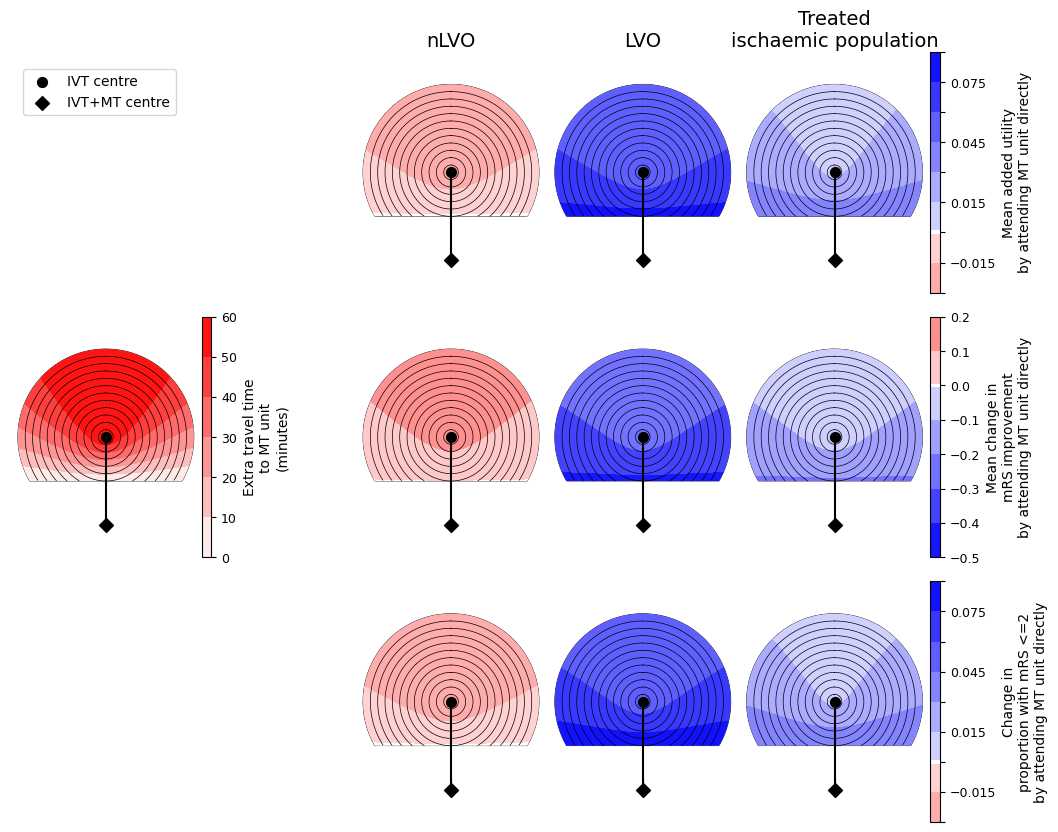

In [22]:
big_outcome_circle_plots(
    -grid_time_travel_directly_diff,
    [df_nlvo_ivt_diff, df_lvo_diff, df_mixed_diff],
    dict_travel_grid,
    plot_params,
    col_titles=['nLVO', 'LVO', 'Treated\nischaemic population'],
    row_titles=[],
    savename=os.path.join(paths.dir_images, f'circle_plots_stroke_type_all_60_60.jpg')
)

## Conclusion

We have created plots of the differences in travel times and in outcomes between patients who travel to the IVT centre and those who travel to the farther MT centre.

In these plots, darker red colours mean a worsening of the outcomes and darker blue colours mean more improvement. We see similar trends across the three outcome measures - it is never the case that one outcome measure improves and another outcome measure worsens. We also see that the benefit from redirection to the farther MT unit is less with increasing extra travel time to the MT unit, i.e. the outcome values are lower at the top of each plot where the extra travel time plot has its highest values.

Generally the nLVO patients have red plots and so have worse outcomes when they travel to the farther MT unit. This is because there are no treatments available at that unit that were not available at the closer IVT-only unit, and so they have only added travel time and so increased the time to treatment with IVT.

Generally the LVO patients have blue plots and so better outcomes when they travel to the farther MT unit. Going directly to this unit substantially decreases the time to MT. For LVO patients, the benefit available from MT is almost always much greater than the benefit from IVT, so prioritising faster MT results in better outcomes.

The results of the mixed population will depend on the exact mix of patients. For this example, on average the population is better off with redirection. This is mostly due to the huge benefit of MT for LVO patients and that subgroup of patients making up a large proportion of the treated ischaemic population.